In [66]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath

from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [67]:
N1, N2, N12, t = np.loadtxt("../data/coincidence_cs137.csv", delimiter=',', unpack=True, skiprows=1)

N1 = unp.uarray(N1, np.sqrt(N1))
N2 = unp.uarray(N2, np.sqrt(N2))
N12 = unp.uarray(N12, np.sqrt(N12))
t = unp.uarray(t, ERROR_TIME)

m1 = N1 / t
m2 = N2 / t
m12 = N12 / t

unique_t = np.unique(t)
print(unique_t)
avg_m1 = unp.uarray(np.zeros_like(unique_t), 0)
avg_m2 = unp.uarray(np.zeros_like(unique_t), 0)
avg_m12 = unp.uarray(np.zeros_like(unique_t), 0)
for i, t_ in enumerate(unique_t):
    avg_m1[i] = np.mean(m1[t == t_])
    avg_m2[i] = np.mean(m2[t == t_])
    avg_m12[i] = np.mean(m12[t == t_])

print(avg_m1, avg_m2, avg_m12)


[189.1+/-0.1 220.2+/-0.1 276.6+/-0.1 304.3+/-0.1]
[2687.9481755684824+/-4.029258809289569
 2686.716621253406+/-3.6999949679091815
 2652.6717281272595+/-3.2419154695623624
 2624.9326322707852+/-3.061084137019169] [2448.1226864093073+/-3.823900637857435
 2460.6584922797456+/-3.524681709092204
 2475.1843817787417+/-3.12239993149886
 2483.506408149852+/-2.971103398112766] [13.225806451612904+/-0.2645557093684523
 13.623978201634879+/-0.2488156093630668
 13.380332610267534+/-0.2199947844407453
 13.144922773578704+/-0.2078843637789359]


In [68]:
# params, *_ = np.linalg.lstsq(
#     (unp.nominal_values(avg_m1*avg_m2))[:,np.newaxis],
#     unp.nominal_values(avg_m12)
# )
coefs, cov = np.polyfit(
    (*unp.nominal_values(avg_m1*avg_m2), 0),
    (*unp.nominal_values(avg_m12), 0),
    1,
    w=(*(1/unp.std_devs(avg_m12)), 1e9),
    cov=True
)
coefs_err = unp.uarray(coefs, np.sqrt(np.diag(cov)))
fitfunc = np.poly1d(coefs)
twotheta = coefs[0]

test_twotheta = avg_m12 / (avg_m1*avg_m2)
print(f'Unique measures {test_twotheta}')
# sigma_twotheta = pass
print(f'Fit: {twotheta}, {coefs}')

Unique measures [2.009870580664845e-06+/-4.041025613932879e-08
 2.0607757472564867e-06+/-3.783504756666592e-08
 2.037867037108105e-06+/-3.368042976700482e-08
 2.0163902654563767e-06+/-3.205256051427625e-08]
Fit: 2.03090568078012e-06, [ 2.03090568e-06 -3.32046735e-20]


In [69]:
with open('../data/2theta_resolution.csv', 'w') as f:
    f.seek(0)
    f.write(str(twotheta))
    f.truncate()

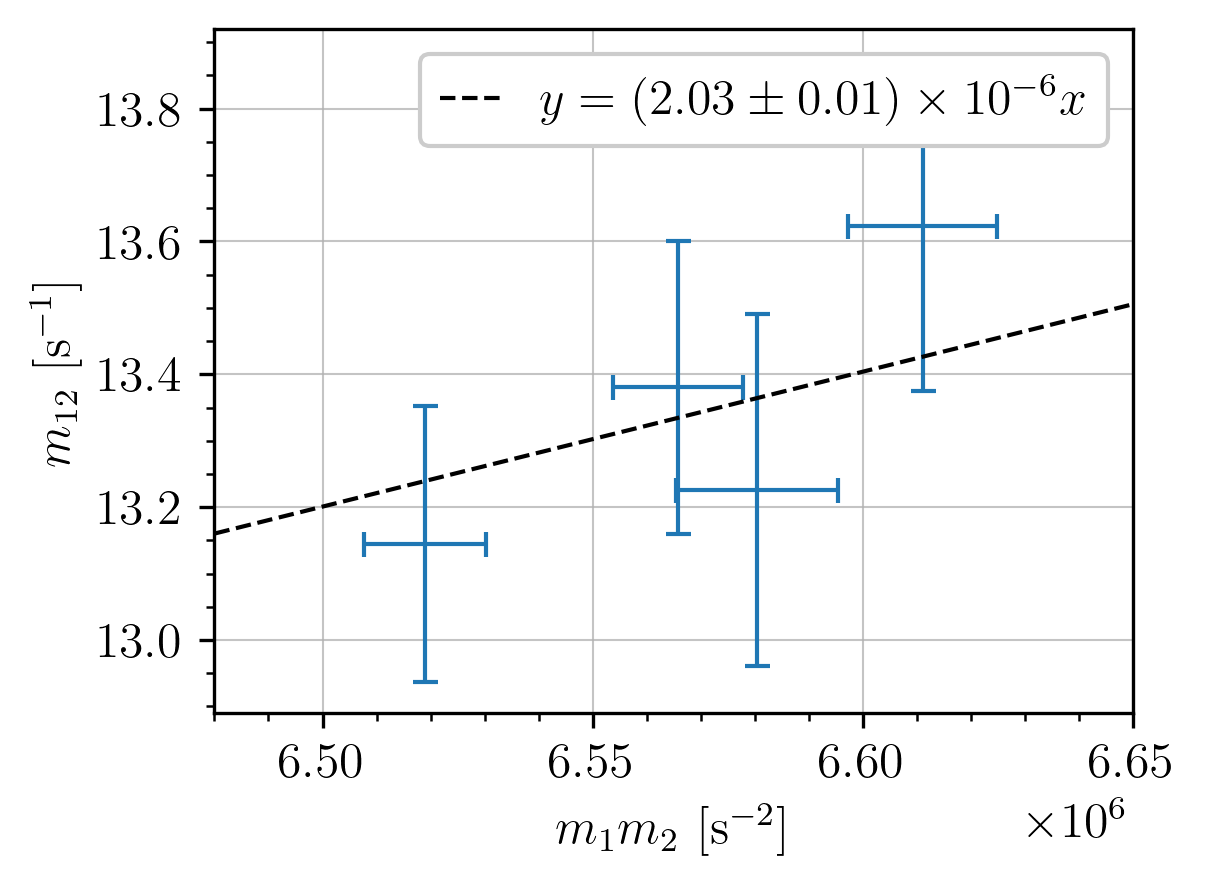

In [70]:

fig, ax = plt.subplots(1,1, dpi=300)

plt.xlabel('$m_1 m_2$ [s$^{-2}$]')
plt.ylabel('$m_{12}$ [s$^{-1}$]')
plt.xlim(6.48e6, 6.65e6)
# x = np.linspace(min(avg_m1*avg_m2).n, max(avg_m1*avg_m2).n, 200)
x = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 200)

plt.errorbar(
    unp.nominal_values(avg_m1*avg_m2),
    unp.nominal_values(avg_m12),
    xerr=unp.std_devs(avg_m1*avg_m2), yerr=unp.std_devs(avg_m12), 
    ls='', capsize=3)

# plt.errorbar(
#     unp.nominal_values(avg_m1*avg_m2)[-4:],
#     unp.nominal_values(avg_m12)[-4:],
#     yerr=unp.std_devs(avg_m12)[-4:], ls='', c='r', capsize=2)
plt.plot(x, fitfunc(x),
         ls='--', c='k',
         label=r'$y = {:.1uepL} x$'.format(*coefs_err))
plt.legend()